# Diseño de Filtros IIR Pasa-Bajas y Pasa-Altas por Transformada Bilineal

## Introducción a los Filtros IIR

Los filtros de Respuesta Infinita al Impulso (IIR) son un tipo de filtro digital cuya respuesta al impulso $h[n]$ es de duración infinita. Esto se debe a la realimentación en su estructura. Son eficientes computacionalmente, pero su fase no es generalmente lineal y su estabilidad debe ser verificada (polos dentro del círculo unitario).

La función de transferencia de un filtro IIR es una función racional de $z^{-1}$:
$$ H(z) = \frac{\sum_{k=0}^{M} b_k z^{-k}}{1 + \sum_{k=1}^{N} a_k z^{-k}} $$

## Método de Diseño por Transformada Bilineal

Este método traduce el diseño de un filtro analógico clásico $H_a(s)$ a un filtro digital $H(z)$. La **transformada bilineal** es una correspondencia entre el plano $s$ y el plano $z$ dada por:
$$ s = \frac{2}{T_s} \frac{1-z^{-1}}{1+z^{-1}} = \frac{2}{T_s} \frac{z-1}{z+1} $$
donde $T_s$ es el periodo de muestreo ($T_s = 1/f_s$).

### Warping de Frecuencia (Pre-distorsión)
La transformada bilineal introduce una distorsión no lineal entre la frecuencia analógica $\Omega$ y la frecuencia digital $\omega$:
$$ \Omega = \frac{2}{T_s} \tan\left(\frac{\omega T_s}{2}\right) $$
Para que el filtro digital tenga sus frecuencias críticas (ej. frecuencia de corte $\omega_c$) en la posición deseada, la $\omega_c$ digital debe ser "pre-warped" a una frecuencia analógica $\Omega_c$ antes de diseñar el filtro analógico. Si $T_s=1$ (frecuencias digitales normalizadas a $f_s$), entonces $\Omega_c = 2 \tan(\omega_c/2)$.
Si $\omega_c$ es la frecuencia de corte de 3 dB, entonces $G_c^2 = 1/2$.

### Prototipos Analógicos
Comúnmente se parte de un prototipo analógico pasabajos normalizado (ej. Butterworth, Chebyshev). Para un filtro pasabajos de primer orden, la función de transferencia analógica puede ser $H_a(s) = \frac{\alpha}{s+\alpha}$. Aplicando la transformada bilineal, se obtienen los coeficientes $a$ y $b$ del filtro digital.

Para filtros pasaaltas, se puede diseñar un prototipo analógico pasabajos y luego aplicar una transformación de frecuencia analógica de pasabajos a pasaaltas antes de la transformada bilineal, o diseñar directamente un filtro pasaaltas digital usando las herramientas de SciPy.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Configuración general para los gráficos
plt.rcParams['figure.figsize'] = [25, 4] 
plt.rcParams['figure.dpi'] = 90      

# --- Funciones para graficar en el Dominio del Tiempo ---

def plot_signal_time_domain(t, signal_data, title="Señal en el Dominio del Tiempo", xlabel="Tiempo (s)", ylabel="Amplitud"):
    """Grafica una señal (amplitud vs. tiempo) dado un vector de tiempo 't'."""
    plt.figure()
    plt.plot(t, signal_data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# --- Funciones para graficar en el Dominio de la Frecuencia ---

def plot_freq_response(w_freq_axis, h_complex_response, title="Respuesta en Frecuencia del Filtro", fs=None):
    """
    Grafica la respuesta de magnitud (dB) y fase de un FILTRO.
    w_freq_axis: eje de frecuencias.
    h_complex_response: respuesta compleja del filtro (salida de signal.freqz).
    fs: frecuencia de muestreo (opcional, para interpretar y etiquetar el eje en Hz).
    """
    fig, axs = plt.subplots(2, 1, figsize=(10,6))
    
    magnitude_db = 20 * np.log10(np.abs(h_complex_response) + 1e-9) 

    freq_axis_label = 'Frecuencia (Hz)' if fs else 'Frecuencia Normalizada'
    w_freq_axis_plot = w_freq_axis 

    if not fs: 
        if np.max(w_freq_axis) <= (np.pi + 1e-3) and np.min(w_freq_axis) >= 0 : 
             freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'
             w_freq_axis_plot = w_freq_axis / np.pi
        elif np.max(w_freq_axis) <= (0.5 + 1e-3) and np.min(w_freq_axis) >= 0: 
             freq_axis_label = 'Frecuencia Normalizada (ciclos/muestra)'

    axs[0].plot(w_freq_axis_plot, magnitude_db)
    axs[0].set_title(f'{title} - Magnitud')
    axs[0].set_xlabel(freq_axis_label)
    axs[0].set_ylabel('Magnitud (dB)')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].set_ylim([-100, max(np.max(magnitude_db) + 10, 10)]) 

    phase = np.unwrap(np.angle(h_complex_response))
    axs[1].plot(w_freq_axis_plot, phase)
    axs[1].set_title(f'{title} - Fase (desenvuelta)')
    axs[1].set_xlabel(freq_axis_label)
    axs[1].set_ylabel('Fase (radianes)')
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_zplane(b, a, title="Diagrama de Polos y Ceros del Filtro Digital"):
    """Grafica el diagrama de polos y ceros de un filtro H(z)=b/a."""
    poles = np.roots(a)
    zeros = np.roots(b)

    plt.figure(figsize=(6,6))
    uc = plt.Circle((0,0), radius=1, fill=False, color='grey', ls='--', alpha=0.7)
    plt.gca().add_patch(uc)

    plt.plot(np.real(zeros), np.imag(zeros), 'o', markersize=8, label='Ceros', mfc='none', c='blue')
    plt.plot(np.real(poles), np.imag(poles), 'x', markersize=8, label='Polos', c='red')

    plt.title(title)
    plt.xlabel('Parte Real (Re)')
    plt.ylabel('Parte Imaginaria (Im)')
    plt.axis('equal') 
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
C:\Users\maxim\AppData\Local\Temp\ipykernel_29080\1936154986.py:39: SyntaxWarning: invalid escape sequence '\p'
  freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'


## Diseño de Filtro IIR Pasabajos (LPF)

Diseñaremos un filtro IIR pasabajos utilizando un prototipo analógico Butterworth. La función `scipy.signal.butter` puede realizar el diseño directamente, manejando el pre-warping y la transformada bilineal.

**Especificaciones Ejemplo:**
* Tipo de filtro: Butterworth.
* Frecuencia de muestreo ($f_s$).
* Frecuencia de corte ($f_c$) (ej. frecuencia de -3dB).
* Orden del filtro ($N$).

Siguiendo el ejemplo:
Filtro pasa-bajos con $f_s=10 \text{ kHz}$ y frecuencia de corte de 3 dB $f_c=1 \text{ kHz}$.
La frecuencia digital de corte es $\omega_c = \frac{2\pi f_c}{f_s} = 0.2\pi \text{ rad/muestra}$.
La frecuencia analógica pre-warped es $\Omega_c = \tan(\frac{\omega_c}{2}) = \tan(0.1\pi) \approx 0.3249 \text{ rad/s}$ (asumiendo $2/T_s$ absorbido o $T_s/2$ en el $\tan$).
Para un filtro de primer orden $H_a(s) = \frac{\Omega_c}{s+\Omega_c}$ (si $\alpha=\Omega_c$ para el corte de 3dB), los coeficientes digitales $a_1$ y $b_0, b_1$ se pueden derivar.
SciPy simplifica esto.

Diseñando Filtro IIR Pasabajos (Butterworth Orden 1):
  Fs = 10000.0 Hz
  Frecuencia de corte fc = 1000.0 Hz

Coeficientes del filtro (numerador b): [0.245237 0.245237]
Coeficientes del filtro (denominador a): [ 1.       -0.509525]


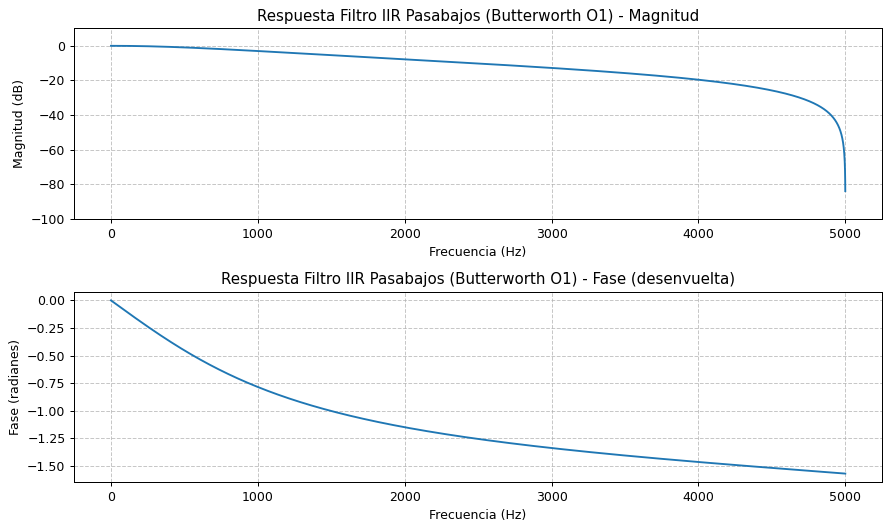

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


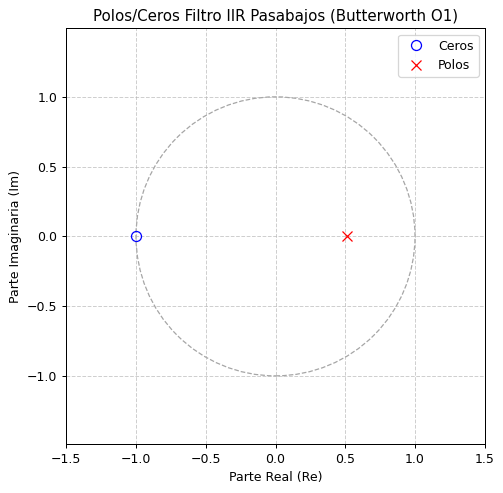

In [6]:
# Especificaciones del filtro digital pasabajos
fs_lpf = 10000.0     # Frecuencia de muestreo (Hz) (ejemplo de la clase)
fc_lpf = 1000.0      # Frecuencia de corte (-3dB) deseada (Hz) (ejemplo de la clase)
order_lpf = 1        # Orden del filtro Butterworth (ejemplo de la clase para H(s)=alpha/(s+alpha))
# order_lpf = 4      # Para un filtro de orden superior

print(f"Diseñando Filtro IIR Pasabajos (Butterworth Orden {order_lpf}):")
print(f"  Fs = {fs_lpf} Hz")
print(f"  Frecuencia de corte fc = {fc_lpf} Hz")

# Diseñar directamente usando signal.butter
# Wn: Frecuencia(s) críticas. Para pasabajos/pasaaltas, es un escalar.
# fs: Frecuencia de muestreo del sistema digital.
b_lpf, a_lpf = signal.butter(N=order_lpf,
                             Wn=fc_lpf, # Frecuencia en Hz
                             btype='lowpass',
                             analog=False,
                             output='ba', 
                             fs=fs_lpf)

print(f"\nCoeficientes del filtro (numerador b): {np.round(b_lpf, 6)}")
print(f"Coeficientes del filtro (denominador a): {np.round(a_lpf, 6)}")

# Para el ejemplo de la clase (orden 1, fc=1kHz, fs=10kHz):
# omega_c_digital = 2 * np.pi * fc_lpf / fs_lpf # 0.2*pi
# Omega_c_analog_prewarped = np.tan(omega_c_digital / 2) # Asumiendo factor 2/Ts = 1 para la fórmula de alpha
# alpha = Omega_c_analog_prewarped # Para corte de -3dB, alpha = Omega_c
# a_manual = (1 - alpha) / (1 + alpha)
# b_manual = alpha / (1 + alpha)
# print(f"Coeficientes calculados manualmente (aproximado para orden 1):")
# print(f"  b0_manual = {b_manual:.4f}, b1_manual = {b_manual:.4f} (esperado b0=b1 para esta forma)") # H(z) = b * (1+z^-1) / (1-a*z^-1)
# print(f"  a1_manual = {-a_manual:.4f}")
# Los coeficientes de SciPy pueden estar normalizados de forma diferente o ser para una estructura directa.
# signal.butter(1, Wn, fs=fs) -> b=[factor, factor], a=[1, factor_a]

# Analizar la respuesta en frecuencia
w_hz_lpf, h_complex_lpf = signal.freqz(b_lpf, a_lpf, worN=8000, fs=fs_lpf)
plot_freq_response(w_hz_lpf, h_complex_lpf, 
                   title=f"Respuesta Filtro IIR Pasabajos (Butterworth O{order_lpf})", 
                   fs=fs_lpf)

# Diagrama de polos y ceros
plot_zplane(b_lpf, a_lpf, title=f"Polos/Ceros Filtro IIR Pasabajos (Butterworth O{order_lpf})")

## Diseño de Filtro IIR Pasaaltas (HPF)

El diseño de un filtro pasaaltas IIR sigue un proceso similar. Se puede partir de un prototipo analógico pasabajos, aplicar una transformación de frecuencia analógica de pasabajos a pasaaltas ($s' \rightarrow \Omega_c / s$), y luego aplicar la transformada bilineal.
Alternativamente, `scipy.signal.butter` (y funciones similares) pueden diseñar el filtro pasaaltas digital directamente.

**Especificaciones Ejemplo:**
* Tipo de filtro: Butterworth.
* Frecuencia de muestreo ($f_s$).
* Frecuencia de corte ($f_c$).
* Orden del filtro ($N$).

Diseñando Filtro IIR Pasaaltas (Butterworth Orden 3):
  Fs = 10000.0 Hz
  Frecuencia de corte fc = 2000.0 Hz

Coeficientes del filtro (numerador b): [ 0.256916 -0.770747  0.770747 -0.256916]
Coeficientes del filtro (denominador a): [ 1.       -0.577241  0.421787 -0.056297]


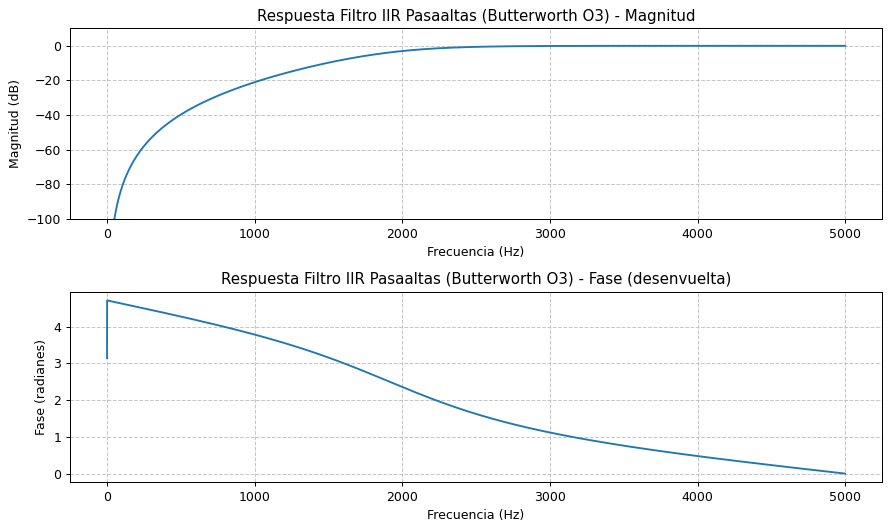

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


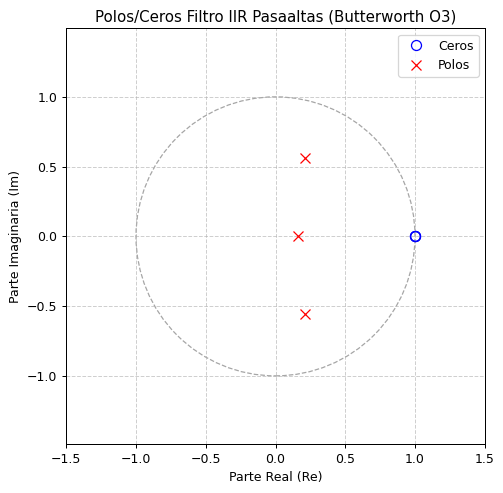

In [7]:
# Especificaciones del filtro digital pasaaltas
fs_hpf = 10000.0     # Frecuencia de muestreo (Hz)
fc_hpf = 2000.0      # Frecuencia de corte (-3dB) deseada (Hz)
order_hpf = 3        # Orden del filtro Butterworth

print(f"Diseñando Filtro IIR Pasaaltas (Butterworth Orden {order_hpf}):")
print(f"  Fs = {fs_hpf} Hz")
print(f"  Frecuencia de corte fc = {fc_hpf} Hz")

b_hpf, a_hpf = signal.butter(N=order_hpf,
                             Wn=fc_hpf, # Frecuencia en Hz
                             btype='highpass',
                             analog=False,
                             output='ba',
                             fs=fs_hpf)

print(f"\nCoeficientes del filtro (numerador b): {np.round(b_hpf, 6)}")
print(f"Coeficientes del filtro (denominador a): {np.round(a_hpf, 6)}")

# Analizar la respuesta en frecuencia
w_hz_hpf, h_complex_hpf = signal.freqz(b_hpf, a_hpf, worN=8000, fs=fs_hpf)
plot_freq_response(w_hz_hpf, h_complex_hpf, 
                   title=f"Respuesta Filtro IIR Pasaaltas (Butterworth O{order_hpf})", 
                   fs=fs_hpf)

# Diagrama de polos y ceros
plot_zplane(b_hpf, a_hpf, title=f"Polos/Ceros Filtro IIR Pasaaltas (Butterworth O{order_hpf})")

## Aplicación de los Filtros IIR Diseñados

Los filtros IIR diseñados se pueden aplicar a señales de prueba utilizando `scipy.signal.lfilter` para observar su comportamiento.

--- Aplicando Filtro Pasabajos ---


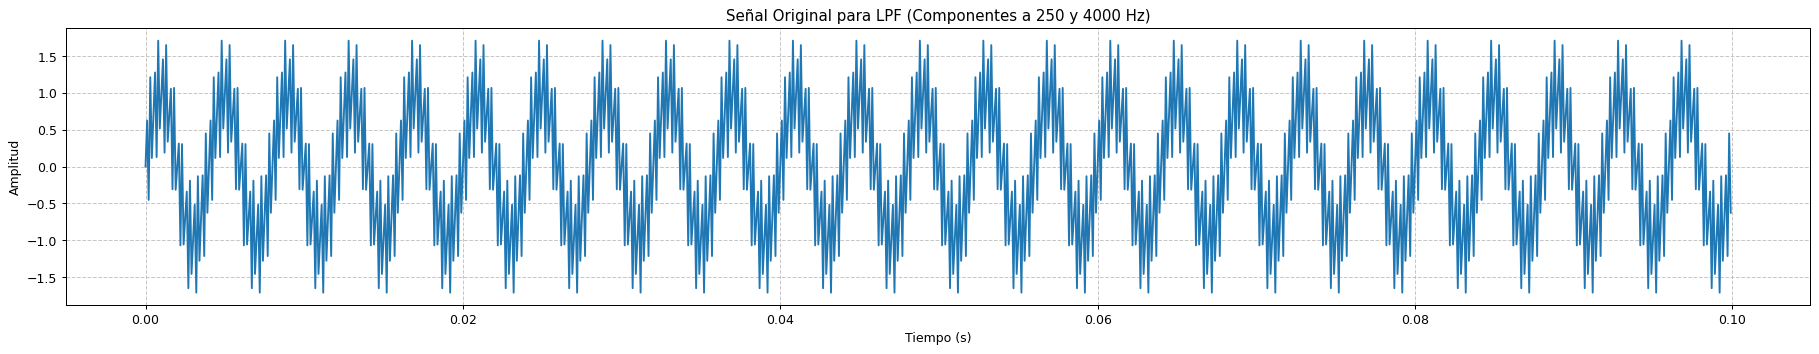

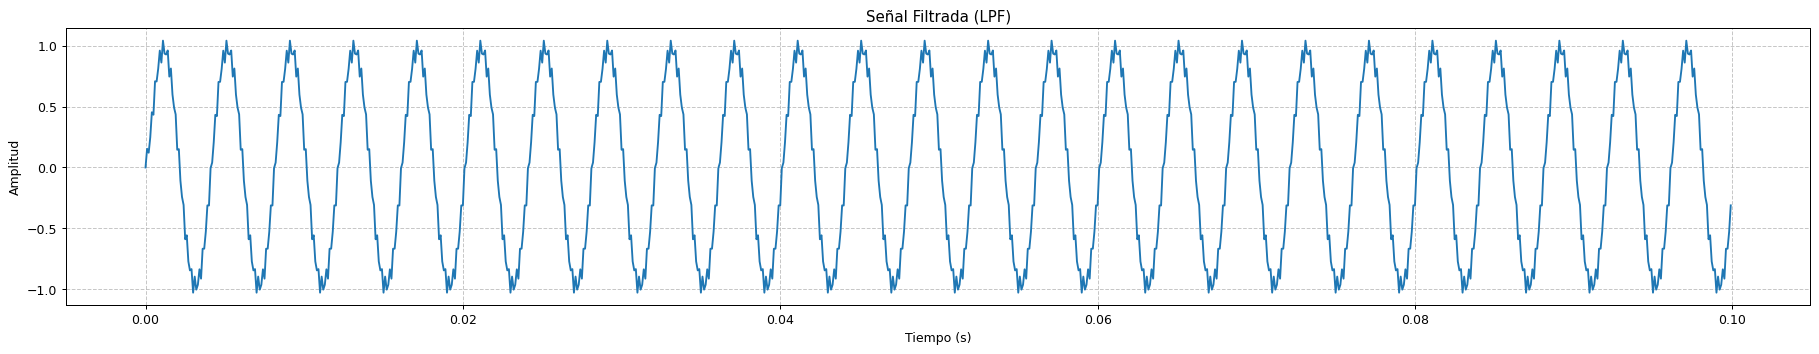


--- Aplicando Filtro Pasaaltas ---


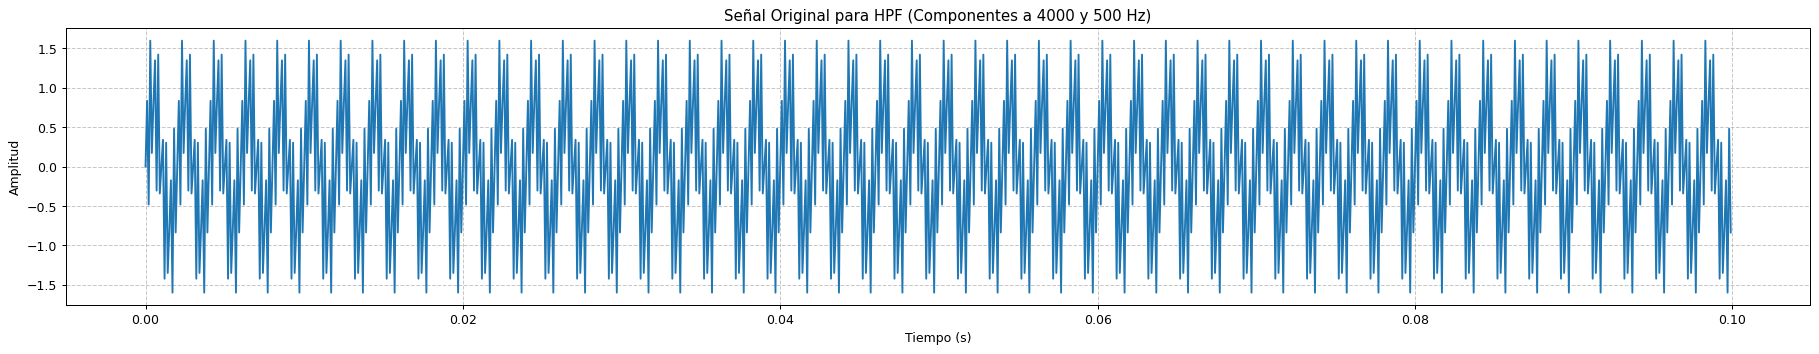

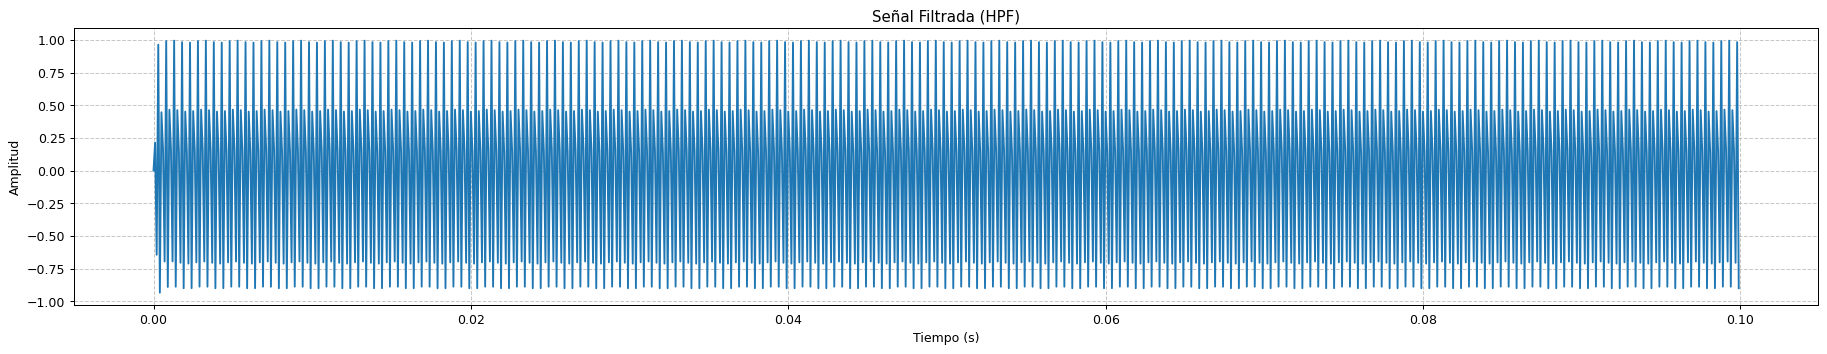

In [8]:
# --- Aplicación del Filtro Pasabajos ---
fs = fs_lpf # Usar la misma fs que para el diseño del LPF
t_test_lpf = np.arange(0, 0.1, 1/fs) # 0.1 segundos de señal

# Componentes: uno bien dentro de la banda de paso, otro bien fuera
f_pass_lpf = fc_lpf / 4.0
f_stop_lpf = fc_lpf * 4.0

sig_pass_lpf = 1.0 * np.sin(2 * np.pi * f_pass_lpf * t_test_lpf)
sig_stop_lpf = 0.8 * np.sin(2 * np.pi * f_stop_lpf * t_test_lpf)
test_signal_lpf = sig_pass_lpf + sig_stop_lpf

print("--- Aplicando Filtro Pasabajos ---")
plot_signal_time_domain(t_test_lpf, test_signal_lpf, title=f"Señal Original para LPF (Componentes a {f_pass_lpf:.0f} y {f_stop_lpf:.0f} Hz)")

# Filtrar la señal
filtered_signal_lpf = signal.lfilter(b_lpf, a_lpf, test_signal_lpf)
plot_signal_time_domain(t_test_lpf, filtered_signal_lpf, title="Señal Filtrada (LPF)")


# --- Aplicación del Filtro Pasaaltas ---
fs = fs_hpf # Usar la misma fs que para el diseño del HPF
t_test_hpf = np.arange(0, 0.1, 1/fs) # 0.1 segundos de señal

# Componentes: uno bien dentro de la banda de paso (alto), otro bien fuera (bajo)
f_pass_hpf = fc_hpf * 2.0 
f_stop_hpf = fc_hpf / 4.0

sig_pass_hpf = 1.0 * np.sin(2 * np.pi * f_pass_hpf * t_test_hpf)
sig_stop_hpf = 0.8 * np.sin(2 * np.pi * f_stop_hpf * t_test_hpf)
test_signal_hpf = sig_pass_hpf + sig_stop_hpf

print("\n--- Aplicando Filtro Pasaaltas ---")
plot_signal_time_domain(t_test_hpf, test_signal_hpf, title=f"Señal Original para HPF (Componentes a {f_pass_hpf:.0f} y {f_stop_hpf:.0f} Hz)")

# Filtrar la señal
filtered_signal_hpf = signal.lfilter(b_hpf, a_hpf, test_signal_hpf)
plot_signal_time_domain(t_test_hpf, filtered_signal_hpf, title="Señal Filtrada (HPF)")